# Credit Card Approval Prediction

**Objetivo:** Construir un modelo de Perceptron Multi Capa para predecir si un individuo solicitando crédito es "bueno" o "malo".

## Introducción

Las "score cards" de crédito son un método común de control de riesgos en la industria financiera. Utilizan información personal y datos enviados por los solicitantes de tarjetas de crédito para predecir la probabilidad de futuros incumplimientos. El banco puede decidir si emitir una tarjeta de crédito al solicitante. Los puntajes crediticios pueden cuantificar objetivamente la magnitud del riesgo.
 
En términos generales, las "score cards" de crédito se basan en datos históricos. El modelo logístico es un método común para la calificación crediticia. "Logistic" es adecuado para tareas de clasificación binaria y puede calcular los coeficientes de cada característica. Para facilitar la comprensión y el funcionamiento, la tarjeta de puntuación multiplicará el coeficiente de regresión logística por un valor determinado (como 100) y lo redondeará.
 
En la actualidad, con el desarrollo de algoritmos de aprendizaje automático. Se han introducido métodos más predictivos como "Boosting", "Random Forest", "Support Vector Machines" y "Multi Layer Perceptron"  en la puntuación de "score cards". 


## Marco Teórico

### Weight of Evidence(WoE):
$$ woe_i = ln \dfrac{P_{y_i}}{P_{n_i}} = ln\left(\frac{y_i/y_s}{n_i/n_s}\right)$$ 
Donde $woe_i$  es la categoría $i$ del valor de WoE.  $P_{y_i}$ es la proporción de muestras positivas (donde positivo para nosotros será no implumplimiento de pago) en la categoría $i$ respecto a todos los registros positivos.  $P_{n_i}$ es la proporción de muestras negativas (donde negativo para nosotros será implumplimiento de pago) en la categoría $i$ respecto a todos los registros negativos.

### Information Value (IV):
$$ IV_i = (P_{y_i}-P{n_i})xwoe_i$$
Los valores de $IV$ de los distintos tipos son la diferencia entre la tasa positiva condicional y la tasa negativa condicional multiplicada por el valor WoE de la variable. El valor de IV total de la variable se puede entender como la suma ponderada de la tasa positiva condicional y la diferencia de tasa condicional negativa:
$$IV = \underset{i}{\overset{n}{\sum}} IV_i  $$

Los valores $IV$ cuantifican la habilidad de la variable para predecir en este caso binario, se estima es de acuerdo a la siguiente tabla:

| Rango $IV$ | Habilidad para predecir |
| --- | --- | 
| ($-\infty$,0.02) | Casi no tiene |
| $[$0.02 - 0.1) | Pobre  |
| $[$0.1 - 0.3)  | Moderado |
| $[$0.3 - 0.5)  | Fuerte |
| $[$0.5 - $\infty$)  | Demasiado fuerte, revisar la variable |


Cargamos las librerías que nos ayudarán a cumplir el objetivo.

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers

In [2]:
import warnings
import pandas as pd    
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import column_or_1d
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,fbeta_score
from datetime import datetime
import csv

Para cumplir nuestro objetivo tenemos dos conjuntos de datos que se relacionan con el "ID", los cuales se pueden encontrar en: https://www.kaggle.com/rikdifos/credit-card-approval-prediction .

- **application_record.** Tiene la información del individuo que solicita un crédito al momento de la solicitud, las variables que tiene son:
    - ID: Identificador del cliente.
    - CODE_GENDER: Género del cliente.
    - FLAG_OWN_CAR: Bandera indicando si el cliente tiene carro.
    - FLAG_OWN_REALTY: Bandera indicando si el cliente tiene alguna propiedad inmueble.
    - CNT_CHILDREN: Cantidad de niños dependientes del cliente.
    - AMT_INCOME_TOTAL: Monto del ingreso del cliente.
    - NAME_INCOME_TYPE: Categoría del ingreso.
    - NAME_EDUCATION_TYPE: Nivel de educación.
    - NAME_FAMILY_STATUS: Estado civil.
    - NAME_HOUSING_TYPE: Tipo de vivienda.
    - DAYS_BIRTH: Cantidad de días desde el momento de la solicitud al nacimiento, -1 significa el día anterior.
    - DAYS_EMPLOYED: Cantidad de días desde el momento de la solicitud al inicio de labores de la persona, -1 significa el día anterior.
    - FLAG_MOBIL: Bandera indicando si el cliente tiene un teléfono móbil.
    - FLAG_WORK_PHONE: Bandera indicando si el cliente tiene un teléfono asociado a su trabajo.
    - FLAG_PHONE: Bandera indicando si el cliente tiene un teléfono fijo asociado.
    - FLAG_EMAIL: Bandera indicando si el cliente tiene correo electrónico.
    - OCCUPATION_TYPE: Tipo de ocupación.
    - CNT_FAM_MEMBERS: Cantidad de miembros familiares con quienes vive.
- **credit_record.** Tiene la información de los cortes de la tareta de crédito asociada a la persona, las variables que tiene son:
    - ID: Identificador del cliente.
    - MONTHS_BALANCE: Cantidad de meses desde el momento de la toma de datos al registro del corte, -1 significa el mes anterior.
    - STATUS: Categoría indicando el estado del corte indicado según el siguiente catálogo.
        - 0: 1-29 días desde el último pago. 
        - 1: 30-59 días desde el último pago.
        - 2: 60-89 días desde el último pago.
        - 3: 90-119 días desde el último pago.
        - 4: 120-149 días desde el último pago.
        - 5: Más de 150 días desde el último pago. (Pérdida) 
        - C: Tarjeta pagada ese mes.
        - X: No existe corte en ese mes.

Cargamos los conjuntos de datos:

In [3]:
data = pd.read_csv("Data/application_record.csv", encoding = 'utf-8') 
record = pd.read_csv("Data/credit_record.csv", encoding = 'utf-8') 

In [4]:
data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [5]:
record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


Empezamos encontrando (relativamente) el mes al que inició el crédito.

In [6]:
mes_inicial = pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
mes_inicial = mes_inicial.rename(columns={'MONTHS_BALANCE':'mes_inicial'}) 
dataset = pd.merge(data,mes_inicial,how="left",on="ID")

Creamos la variable binaria con la que haremos la clasificacion, calibrada a un minimo de 60 días de impago.

In [7]:
record['Variable_Objetivo'] = None
record['Variable_Objetivo'][record['STATUS'] =='2']= 1
record['Variable_Objetivo'][record['STATUS'] =='3']= 1 
record['Variable_Objetivo'][record['STATUS'] =='4']= 1
record['Variable_Objetivo'][record['STATUS'] =='5']= 1 

C:\Users\jose-\Anaconda3\envs\tensorflowGPU\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\jose-\Anaconda3\envs\tensorflowGPU\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\jose-\Anaconda3\envs\tensorflowGPU\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [8]:
C_Variable_Objetivo = Counter(record['Variable_Objetivo'])
C_Variable_Objetivo

Counter({None: 1045471, 1: 3104})

Vemos como éste dataset está desbalanceado como esperado. Procedemos ahora a crear el dataset final al hacer la unión de la información de las solicitudes con la Variable Objetivo obtenida anteriormente.

In [9]:
cpunt=record.groupby('ID').count()
cpunt['Variable_Objetivo'][cpunt['Variable_Objetivo'] > 0] = 1
cpunt['Variable_Objetivo'][cpunt['Variable_Objetivo'] == 0] = 0 
cpunt = cpunt[['Variable_Objetivo']]
dataset=pd.merge(dataset,cpunt,how='inner',on='ID')

In [10]:
print(cpunt['Variable_Objetivo'].value_counts())
cpunt['Variable_Objetivo'].value_counts(normalize=True)

0    45318
1      667
Name: Variable_Objetivo, dtype: int64


0    0.985495
1    0.014505
Name: Variable_Objetivo, dtype: float64

In [11]:
dataset.shape

(36457, 20)

In [12]:
dataset.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,mes_inicial,Variable_Objetivo
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0


In [13]:
dataset['Variable_Objetivo'].value_counts(normalize=True)

0    0.983103
1    0.016897
Name: Variable_Objetivo, dtype: float64

## Ingeniería de Atributos

Convertimos la columna ID en índice ya que ésta no tiene relevancia predictiva y ayuda más como ínidice para la particion y recreación de los dataset. Adicionalmente creamos listas para las variables x y la variable binaria objetivo.

In [14]:
dataset = dataset.set_index('ID')

In [15]:
Var_y = 'Variable_Objetivo'
Var_x = list(dataset.columns)
Var_x.remove(Var_y)

Buscamos variables que tengan registros con valores null.

In [16]:
for i in Var_x:
    piv_c = dataset[i]
    if len(piv_c[piv_c.isnull()])>0:
        print(i,len(piv_c[piv_c.isnull()])/len(piv_c))

OCCUPATION_TYPE 0.3105850728255205


Puesto que la variable 'OCCUPATION_TYPE' es la única con valores null le hacemos una imputación según su catálogo.

In [17]:
C_OCCUPATION_TYPE = Counter(dataset['OCCUPATION_TYPE'])
C_OCCUPATION_TYPE

Counter({nan: 11323,
         'Security staff': 592,
         'Sales staff': 3485,
         'Accountants': 1241,
         'Laborers': 6211,
         'Managers': 3012,
         'Drivers': 2138,
         'Core staff': 3591,
         'High skill tech staff': 1383,
         'Cleaning staff': 551,
         'Private service staff': 344,
         'Cooking staff': 655,
         'Low-skill Laborers': 175,
         'Medicine staff': 1207,
         'Secretaries': 151,
         'Waiters/barmen staff': 174,
         'HR staff': 85,
         'Realty agents': 79,
         'IT staff': 60})

Se decide crear el camo 'Others'.

In [18]:
piv_c = dataset['OCCUPATION_TYPE']
piv_c[piv_c.isnull()] = 'Others' 

C:\Users\jose-\Anaconda3\envs\tensorflowGPU\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
C_OCCUPATION_TYPE = Counter(dataset['OCCUPATION_TYPE'])
C_OCCUPATION_TYPE

Counter({'Others': 11323,
         'Security staff': 592,
         'Sales staff': 3485,
         'Accountants': 1241,
         'Laborers': 6211,
         'Managers': 3012,
         'Drivers': 2138,
         'Core staff': 3591,
         'High skill tech staff': 1383,
         'Cleaning staff': 551,
         'Private service staff': 344,
         'Cooking staff': 655,
         'Low-skill Laborers': 175,
         'Medicine staff': 1207,
         'Secretaries': 151,
         'Waiters/barmen staff': 174,
         'HR staff': 85,
         'Realty agents': 79,
         'IT staff': 60})

In [20]:
dataset.dropna()
dataset = dataset.mask(dataset == 'NULL').dropna()

C:\Users\jose-\Anaconda3\envs\tensorflowGPU\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\Users\jose-\Anaconda3\envs\tensorflowGPU\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


Construimos una función para calcular los valores de $IV$ de las variables, dada que es una definición para cada valor de una variable tenemos que contruir todas las variables numéricas a categóricas.

In [21]:
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Valor
                    df[df[feature] == val].count()[feature],                        # Total
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Cantidad de buenos
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Cantidad de malos

    data = pd.DataFrame(lst, columns=['Variable', 'Valor', 'Total', 'Buenos', 'Malos'])
    data['Proporción'] = data['Total'] / data['Total'].sum()
    data['Razón de Malos'] = data['Malos'] / data['Total']
    data['Distribución de Buenos'] = (data['Total'] - data['Malos']) / (data['Total'].sum() - data['Malos'].sum())
    data['Distribución de Malos'] = data['Malos'] / data['Malos'].sum()
    data['WoE'] = np.log(data['Distribución de Buenos'] / data['Distribución de Malos'])
    
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribución de Buenos'] - data['Distribución de Malos'])

    data = data.sort_values(by=['Variable', 'Valor'], ascending=[True, True])
    data.index = range(len(data.index))

    iv = data['IV'].sum()
    return iv, data

Ahora creamos la tabla para almacenar los valores $IV$.

In [22]:
ivtable=pd.DataFrame(dataset.columns,columns=['variable'])
ivtable['IV']=None
namelist = ['mes_inicial','Variable_Objetivo']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)

In [23]:
ivtable

,variable,IV
0,CODE_GENDER,None
1,FLAG_OWN_CAR,None
2,FLAG_OWN_REALTY,None
3,CNT_CHILDREN,None
4,AMT_INCOME_TOTAL,None
5,NAME_INCOME_TYPE,None
6,NAME_EDUCATION_TYPE,None
7,NAME_FAMILY_STATUS,None
8,NAME_HOUSING_TYPE,None
9,DAYS_BIRTH,None


Creamos una partición de las variables según su tipo.

In [24]:
Vars_type = {'str':[],'int':[],'float':[]}
for i in Var_x:
    if type(list(dataset[i])[0]) == str:
        Vars_type['str'].append(i)
        continue
    if type(list(dataset[i])[0]) == int:
        Vars_type['int'].append(i)
        continue
    if type(list(dataset[i])[0]) == float:
        Vars_type['float'].append(i)        

### Variables tipo string

A las variables categóricas vamos a convertirlas a variables tipo dummy, de acuerdo a la siguiente función, que será aplicada luego de obtener el valor $IV$ de la variable.

In [25]:
Vars_type['str']

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE']

In [26]:
def convert_dummy(df, feature,rank=0):
    pos = pd.get_dummies(df[feature], prefix=feature)
    mode = df[feature].value_counts().index[rank]
    biggest = feature + '_' + str(mode)
    pos.drop([biggest],axis=1,inplace=True)
    df.drop([feature],axis=1,inplace=True)
    df=df.join(pos)
    return df

#### CODE_GENDER

In [27]:
Counter(dataset['CODE_GENDER'])

Counter({'M': 12027, 'F': 24430})

In [28]:
dataset['CODE_GENDER'] = dataset['CODE_GENDER'].replace(['F','M'],[0,1])
print(dataset['CODE_GENDER'].value_counts())
iv, data = calc_iv(dataset,'CODE_GENDER','Variable_Objetivo')
ivtable.loc[ivtable['variable']=='CODE_GENDER','IV']=iv

0    24430
1    12027
Name: CODE_GENDER, dtype: int64


#### FLAG_OWN_CAR

In [29]:
Counter(dataset['FLAG_OWN_CAR'])

Counter({'Y': 13843, 'N': 22614})

In [30]:
dataset['FLAG_OWN_CAR'] = dataset['FLAG_OWN_CAR'].replace(['N','Y'],[0,1])
print(dataset['FLAG_OWN_CAR'].value_counts())
iv, data = calc_iv(dataset,'FLAG_OWN_CAR','Variable_Objetivo')
ivtable.loc[ivtable['variable']=='FLAG_OWN_CAR','IV']=iv

0    22614
1    13843
Name: FLAG_OWN_CAR, dtype: int64


#### FLAG_OWN_REALTY

In [31]:
Counter(dataset['FLAG_OWN_REALTY'])

Counter({'Y': 24506, 'N': 11951})

In [32]:
dataset['FLAG_OWN_REALTY'] = dataset['FLAG_OWN_REALTY'].replace(['N','Y'],[0,1])
print(dataset['FLAG_OWN_REALTY'].value_counts())
iv, data = calc_iv(dataset,'FLAG_OWN_REALTY','Variable_Objetivo')
ivtable.loc[ivtable['variable']=='FLAG_OWN_REALTY','IV']=iv

1    24506
0    11951
Name: FLAG_OWN_REALTY, dtype: int64


#### NAME_INCOME_TYPE

In [33]:
Counter(dataset['NAME_INCOME_TYPE'])

Counter({'Working': 18819,
         'Commercial associate': 8490,
         'Pensioner': 6152,
         'State servant': 2985,
         'Student': 11})

Mapeamos a 'Pensioner' y 'Student' a 'State servant' para reducir la cantidad de categorias.

In [34]:
dataset.loc[dataset['NAME_INCOME_TYPE']=='Pensioner','NAME_INCOME_TYPE']='State servant'
dataset.loc[dataset['NAME_INCOME_TYPE']=='Student','NAME_INCOME_TYPE']='State servant'
iv, data=calc_iv(dataset,'NAME_INCOME_TYPE','Variable_Objetivo')
ivtable.loc[ivtable['variable']=='NAME_INCOME_TYPE','IV']=iv
dataset = convert_dummy(dataset,'NAME_INCOME_TYPE')

In [35]:
dataset.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,mes_inicial,Variable_Objetivo,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_State servant
ID,,,,,,,,,,,,,,,,,,,,
5008804,1,1,1,0,427500.0,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Others,2.0,-15.0,0,0,0
5008805,1,1,1,0,427500.0,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Others,2.0,-14.0,0,0,0
5008806,1,1,1,0,112500.0,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0,0,0
5008808,0,0,1,0,270000.0,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0,1,0
5008809,0,0,1,0,270000.0,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0,1,0


#### NAME_EDUCATION_TYPE

In [36]:
Counter(dataset['NAME_EDUCATION_TYPE'])

Counter({'Higher education': 9864,
         'Secondary / secondary special': 24777,
         'Incomplete higher': 1410,
         'Lower secondary': 374,
         'Academic degree': 32})

Mapeamos a 'Academic degree' a 'Higher education' para reducir la cantidad de categorias.

In [37]:
dataset.loc[dataset['NAME_EDUCATION_TYPE']=='Academic degree','NAME_EDUCATION_TYPE']='Higher education'
iv, data=calc_iv(dataset,'NAME_EDUCATION_TYPE','Variable_Objetivo')
ivtable.loc[ivtable['variable']=='NAME_EDUCATION_TYPE','IV']=iv
dataset = convert_dummy(dataset,'NAME_EDUCATION_TYPE')

#### NAME_FAMILY_STATUS

In [38]:
Counter(dataset['NAME_FAMILY_STATUS'])

Counter({'Civil marriage': 2945,
         'Married': 25048,
         'Single / not married': 4829,
         'Separated': 2103,
         'Widow': 1532})

In [39]:
iv, data=calc_iv(dataset,'NAME_FAMILY_STATUS','Variable_Objetivo')
ivtable.loc[ivtable['variable']=='NAME_FAMILY_STATUS','IV']=iv
dataset = convert_dummy(dataset,'NAME_FAMILY_STATUS')

#### NAME_HOUSING_TYPE

In [40]:
Counter(dataset['NAME_HOUSING_TYPE'])

Counter({'Rented apartment': 575,
         'House / apartment': 32548,
         'Municipal apartment': 1128,
         'With parents': 1776,
         'Co-op apartment': 168,
         'Office apartment': 262})

In [41]:
iv, data=calc_iv(dataset,'NAME_HOUSING_TYPE','Variable_Objetivo')
ivtable.loc[ivtable['variable']=='NAME_HOUSING_TYPE','IV']=iv
dataset = convert_dummy(dataset,'NAME_HOUSING_TYPE')

#### OCCUPATION_TYPE

In [42]:
Counter(dataset['OCCUPATION_TYPE'])

Counter({'Others': 11323,
         'Security staff': 592,
         'Sales staff': 3485,
         'Accountants': 1241,
         'Laborers': 6211,
         'Managers': 3012,
         'Drivers': 2138,
         'Core staff': 3591,
         'High skill tech staff': 1383,
         'Cleaning staff': 551,
         'Private service staff': 344,
         'Cooking staff': 655,
         'Low-skill Laborers': 175,
         'Medicine staff': 1207,
         'Secretaries': 151,
         'Waiters/barmen staff': 174,
         'HR staff': 85,
         'Realty agents': 79,
         'IT staff': 60})

Mapeamos 'Cleaning staff',  'Cooking staff', 'Drivers', 'Laborers', 'Low-skill Laborers', 'Security staff', 'Waiters/barmen staff' a una categoria común 'Laborwk'.

También mapeamos 'Accountants', 'Core staff', 'HR staff', 'Medicine staf', 'Private service staff', 'Realty agents', 'Sales staff', 'Secretaries' a una categoría común 'officewk'.

También mapeamos 'Managers', 'High skill tech staff', 'IT staff' a una categoría común 'hightecwk'.

In [43]:
dataset.loc[(dataset['OCCUPATION_TYPE']=='Cleaning staff') | (dataset['OCCUPATION_TYPE']=='Cooking staff') | (dataset['OCCUPATION_TYPE']=='Drivers') | (dataset['OCCUPATION_TYPE']=='Laborers') | (dataset['OCCUPATION_TYPE']=='Low-skill Laborers') | (dataset['OCCUPATION_TYPE']=='Security staff') | (dataset['OCCUPATION_TYPE']=='Waiters/barmen staff'),'OCCUPATION_TYPE']='Laborwk'
dataset.loc[(dataset['OCCUPATION_TYPE']=='Accountants') | (dataset['OCCUPATION_TYPE']=='Core staff') | (dataset['OCCUPATION_TYPE']=='HR staff') | (dataset['OCCUPATION_TYPE']=='Medicine staff') | (dataset['OCCUPATION_TYPE']=='Private service staff') | (dataset['OCCUPATION_TYPE']=='Realty agents') | (dataset['OCCUPATION_TYPE']=='Sales staff') | (dataset['OCCUPATION_TYPE']=='Secretaries'),'OCCUPATION_TYPE']='officewk'
dataset.loc[(dataset['OCCUPATION_TYPE']=='Managers') | (dataset['OCCUPATION_TYPE']=='High skill tech staff') | (dataset['OCCUPATION_TYPE']=='IT staff'),'OCCUPATION_TYPE']='hightecwk'
print(dataset['OCCUPATION_TYPE'].value_counts())
iv, data=calc_iv(dataset,'OCCUPATION_TYPE','Variable_Objetivo')
ivtable.loc[ivtable['variable']=='OCCUPATION_TYPE','IV']=iv
dataset = convert_dummy(dataset,'OCCUPATION_TYPE')

Others       11323
Laborwk      10496
officewk     10183
hightecwk     4455
Name: OCCUPATION_TYPE, dtype: int64


### Variables enteras
Para las variables numéricas las vamos a convertir a categorías de acuerdo a la siguiente función:

In [44]:
def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # Distribución en cuanto a cuantiles
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # Distribución en cuanto a distancias equivalentes
        
    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

In [45]:
Vars_type['int']

['CNT_CHILDREN',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'FLAG_MOBIL',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL']

#### CNT_CHILDREN

<AxesSubplot:ylabel='Frequency'>

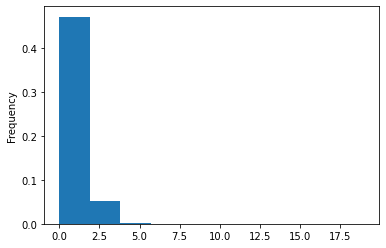

In [46]:
dataset['CNT_CHILDREN'].plot(kind='hist',bins=10,density=True)

Vemos que agrupar a partir de dos es una buena opción.

In [47]:
dataset.loc[dataset['CNT_CHILDREN'] >= 2,'CNT_CHILDREN']='2More'
print(dataset['CNT_CHILDREN'].value_counts(sort=False))
iv, data=calc_iv(dataset,'CNT_CHILDREN','Variable_Objetivo')
ivtable.loc[ivtable['variable']=='CNT_CHILDREN','IV']=iv
dataset = convert_dummy(dataset,'CNT_CHILDREN')

0        25201
1         7492
2More     3764
Name: CNT_CHILDREN, dtype: int64


#### DAYS_BIRTH

<AxesSubplot:ylabel='Frequency'>

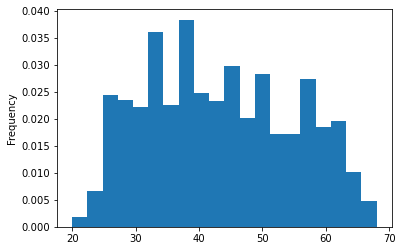

In [48]:
dataset['DAYS_BIRTH'] = -(dataset['DAYS_BIRTH'])//365
dataset['DAYS_BIRTH'].plot(kind='hist',bins=20,density=True)

Hacemos cambio de nombre ya que la variable fue transformada de significado.

In [49]:
dataset = dataset.rename(columns={'DAYS_BIRTH': 'Age'})
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','variable']='Age'

In [50]:
dataset = get_category(dataset,'Age',5, ["lowest","low","medium","high","highest"])
iv, data = calc_iv(dataset,'gp_Age','Variable_Objetivo')
ivtable.loc[ivtable['variable']=='Age','IV'] = iv
dataset = convert_dummy(dataset,'gp_Age')

#### DAYS_EMPLOYED

Hacemos un mapeo de la variable, si luego del mapeo hay valores negativos los amputamos con 'np.nan' para posteriormente llenarlos con la media de la variable.

C:\Users\jose-\Anaconda3\envs\tensorflowGPU\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:ylabel='Frequency'>

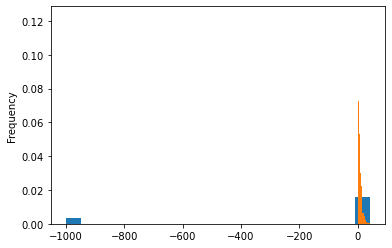

In [51]:
dataset['DAYS_EMPLOYED'] = -(dataset['DAYS_EMPLOYED'])//365
dataset['DAYS_EMPLOYED'].plot(kind='hist',bins=20,density=True)
dataset['DAYS_EMPLOYED'][dataset['DAYS_EMPLOYED']<0] = np.nan
dataset['DAYS_EMPLOYED'].fillna(dataset['DAYS_EMPLOYED'].mean(),inplace=True)
dataset['DAYS_EMPLOYED'].plot(kind='hist',bins=20,density=True)

Hacemos cambio de nombre ya que la variable fue transformada de significado.

In [52]:
dataset = dataset.rename(columns={'DAYS_EMPLOYED': 'WorkTime'})
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','variable']='WorkTime'

In [53]:
dataset = get_category(dataset,'WorkTime',5, ["lowest","low","medium","high","highest"])
iv, data = calc_iv(dataset,'gp_WorkTime','Variable_Objetivo')
ivtable.loc[ivtable['variable']=='WorkTime','IV'] = iv
dataset = convert_dummy(dataset,'gp_WorkTime')

#### FLAG_MOBIL

In [54]:
Counter(dataset['FLAG_MOBIL'])

Counter({1: 36457})

Descartamos la variable.

In [55]:
namelist = ['FLAG_MOBIL']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)

#### FLAG_WORK_PHONE

In [56]:
Counter(dataset['FLAG_WORK_PHONE'])

Counter({1: 8222, 0: 28235})

In [57]:
iv, data=calc_iv(dataset,'FLAG_WORK_PHONE','Variable_Objetivo')
ivtable.loc[ivtable['variable']=='FLAG_WORK_PHONE','IV']=iv

#### FLAG_PHONE

In [58]:
Counter(dataset['FLAG_PHONE'])

Counter({0: 25709, 1: 10748})

In [59]:
iv, data=calc_iv(dataset,'FLAG_PHONE','Variable_Objetivo')
ivtable.loc[ivtable['variable']=='FLAG_PHONE','IV']=iv

#### FLAG_EMAIL

In [60]:
Counter(dataset['FLAG_EMAIL'])

Counter({0: 33186, 1: 3271})

In [61]:
iv, data=calc_iv(dataset,'FLAG_EMAIL','Variable_Objetivo')
ivtable.loc[ivtable['variable']=='FLAG_EMAIL','IV']=iv

### Variables flotantes

In [62]:
Vars_type['float']

['AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS', 'mes_inicial']

#### AMT_INCOME_TOTAL

<AxesSubplot:ylabel='Frequency'>

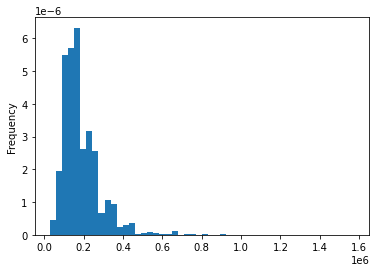

In [63]:
dataset['AMT_INCOME_TOTAL'].plot(kind='hist',bins=50,density=True)

Creamos tres categorías de ingresos según cuantiles.

In [64]:
dataset = get_category(dataset,'AMT_INCOME_TOTAL', 3, ["low","medium", "high"], qcut = True)
iv, data = calc_iv(dataset,'gp_AMT_INCOME_TOTAL','Variable_Objetivo')
ivtable.loc[ivtable['variable']=='AMT_INCOME_TOTAL','IV']=iv
dataset = convert_dummy(dataset,'gp_AMT_INCOME_TOTAL')

#### CNT_FAM_MEMBERS

In [65]:
Counter(dataset['CNT_FAM_MEMBERS'])

Counter({2.0: 19463,
         1.0: 6987,
         5.0: 397,
         3.0: 6421,
         4.0: 3106,
         6.0: 58,
         15.0: 3,
         7.0: 19,
         20.0: 1,
         9.0: 2})

Haremos una agrupación a partir de 3.

In [66]:
dataset.loc[dataset['CNT_FAM_MEMBERS']>=3,'CNT_FAM_MEMBERS']='3more'
iv, data = calc_iv(dataset,'CNT_FAM_MEMBERS','Variable_Objetivo')
ivtable.loc[ivtable['variable']=='CNT_FAM_MEMBERS','IV']=iv
dataset = convert_dummy(dataset,'CNT_FAM_MEMBERS')

Ahora ya tenemos un dataset totalmente numérico y una estimación de la significancia de las variables.

In [67]:
dataset.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,Age,WorkTime,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,...,gp_Age_lowest,gp_Age_medium,gp_WorkTime_high,gp_WorkTime_highest,gp_WorkTime_low,gp_WorkTime_medium,gp_AMT_INCOME_TOTAL_high,gp_AMT_INCOME_TOTAL_medium,CNT_FAM_MEMBERS_1.0,CNT_FAM_MEMBERS_3more
ID,,,,,,,,,,,,,,,,,,,,,
5008804,1,1,1,427500.0,32,12.0,1,1,0,0,...,0,0,0,0,1,0,1,0,0,0
5008805,1,1,1,427500.0,32,12.0,1,1,0,0,...,0,0,0,0,1,0,1,0,0,0
5008806,1,1,1,112500.0,58,3.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5008808,0,0,1,270000.0,52,8.0,1,0,1,1,...,0,0,0,0,0,0,1,0,1,0
5008809,0,0,1,270000.0,52,8.0,1,0,1,1,...,0,0,0,0,0,0,1,0,1,0


In [68]:
ivtable

,variable,IV
0,CODE_GENDER,0.0135814
1,FLAG_OWN_CAR,0.0011443
2,FLAG_OWN_REALTY,0.0283492
3,CNT_CHILDREN,0.000748251
4,AMT_INCOME_TOTAL,0.00357237
5,NAME_INCOME_TYPE,0.00239048
6,NAME_EDUCATION_TYPE,0.00916484
7,NAME_FAMILY_STATUS,0.0301193
8,NAME_HOUSING_TYPE,0.0157111
9,Age,0.0089606


Hacemos una exploración del conjunto de datos:

In [69]:
dataset.describe()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,Age,WorkTime,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,...,gp_Age_lowest,gp_Age_medium,gp_WorkTime_high,gp_WorkTime_highest,gp_WorkTime_low,gp_WorkTime_medium,gp_AMT_INCOME_TOTAL_high,gp_AMT_INCOME_TOTAL_medium,CNT_FAM_MEMBERS_1.0,CNT_FAM_MEMBERS_3more
count,36457.000000,36457.000000,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,...,36457.000000,36457.000000,36457.000000,36457.000000,36457.00000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,0.329895,0.379708,0.672189,1.866857e+05,43.260334,6.750544,1.0,0.225526,0.294813,0.089722,...,0.135173,0.234962,0.014346,0.003319,0.16765,0.045506,0.309460,0.293551,0.191650,0.274488
std,0.470181,0.485321,0.469422,1.017892e+05,11.510414,5.899153,0.0,0.417934,0.455965,0.285787,...,0.341913,0.423981,0.118913,0.057516,0.37356,0.208413,0.462278,0.455395,0.393605,0.446262
min,0.000000,0.000000,0.000000,2.700000e+04,20.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.215000e+05,34.000000,3.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,1.575000e+05,42.000000,6.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,2.250000e+05,53.000000,8.000000,1.0,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.575000e+06,68.000000,43.000000,1.0,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


Elegimos variables de acuerdo a su valor IV, si tienen menos de 0.002 descartamos.

In [70]:
NombreColumnas = list(dataset.columns)
NombreColumnas.sort()
NombreColumnas

['AMT_INCOME_TOTAL',
 'Age',
 'CNT_CHILDREN_1',
 'CNT_CHILDREN_2More',
 'CNT_FAM_MEMBERS_1.0',
 'CNT_FAM_MEMBERS_3more',
 'CODE_GENDER',
 'FLAG_EMAIL',
 'FLAG_MOBIL',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FLAG_PHONE',
 'FLAG_WORK_PHONE',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_EDUCATION_TYPE_Incomplete higher',
 'NAME_EDUCATION_TYPE_Lower secondary',
 'NAME_FAMILY_STATUS_Civil marriage',
 'NAME_FAMILY_STATUS_Separated',
 'NAME_FAMILY_STATUS_Single / not married',
 'NAME_FAMILY_STATUS_Widow',
 'NAME_HOUSING_TYPE_Co-op apartment',
 'NAME_HOUSING_TYPE_Municipal apartment',
 'NAME_HOUSING_TYPE_Office apartment',
 'NAME_HOUSING_TYPE_Rented apartment',
 'NAME_HOUSING_TYPE_With parents',
 'NAME_INCOME_TYPE_Commercial associate',
 'NAME_INCOME_TYPE_State servant',
 'OCCUPATION_TYPE_Laborwk',
 'OCCUPATION_TYPE_hightecwk',
 'OCCUPATION_TYPE_officewk',
 'Variable_Objetivo',
 'WorkTime',
 'gp_AMT_INCOME_TOTAL_high',
 'gp_AMT_INCOME_TOTAL_medium',
 'gp_Age_high',
 'gp_Age_highest',
 'gp_Ag

In [71]:
ivtable['variable'][ivtable['IV']<0.002]

1        FLAG_OWN_CAR
3        CNT_CHILDREN
12    FLAG_WORK_PHONE
13         FLAG_PHONE
14         FLAG_EMAIL
Name: variable, dtype: object

In [72]:
var_out = set(['AMT_INCOME_TOTAL',
 'Age',
 'FLAG_EMAIL',
 'FLAG_MOBIL',
 'FLAG_OWN_CAR',
 'FLAG_PHONE',
 'NAME_FAMILY_STATUS_Widow',
 'NAME_INCOME_TYPE_Commercial associate',
 'NAME_INCOME_TYPE_State servant',
 'WorkTime',
 'gp_AMT_INCOME_TOTAL_high',
 'gp_AMT_INCOME_TOTAL_medium',
 'mes_inicial'])

In [73]:
NombreColumnas = list(set(NombreColumnas)-var_out)
dataset = dataset[NombreColumnas]
Var_x = list(dataset.columns)
Var_x.remove(Var_y)

Separamos el dataset en 3 conjuntos.

In [74]:
dataset[Var_x].shape

(36457, 29)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(dataset[Var_x],dataset[Var_y], 
                                                    stratify=dataset[Var_y], test_size=0.2,
                                                    random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, 
                                                    stratify=y_train, test_size=0.2,
                                                    random_state = 0)
X_balance,Y_balance = SMOTE().fit_sample(dataset[Var_x],dataset[Var_y])
X_train_balance, X_val_balance, y_train_balance, y_val_balance = train_test_split(X_balance,Y_balance, 
                                                    stratify=Y_balance, test_size=0.2,
                                                    random_state = 0)
X_balance = pd.DataFrame(X_balance, columns = X_balance.columns)
X_train_balance, X_test_balance, y_train_balance, y_test_balance = train_test_split(X_train_balance,y_train_balance, 
                                                    stratify=y_train_balance, test_size=0.2,
                                                    random_state = 0)

Calculamos pesos para utilizar en el dataset desbalanceado.

In [76]:
Class_Weight = dict(Counter(dataset[Var_y]))

In [77]:
for i in Class_Weight:
    Class_Weight[i] = len(dataset)/Class_Weight[i]

### Red neuronal (Multi-layer Perceptron)
#### Balanceo con peso
##### Optimizador Adan

In [78]:
if 'model' in globals():
    del model
model = models.Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1920      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 5,089
Trainable params: 5,089
Non-trainable params: 0
_________________________________________________________________


In [79]:
model.compile(optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [80]:
history = model.fit(X_train, y_train,
                    epochs = 64,
                    batch_size = 128,
                    validation_data = (X_val, y_val),
                    class_weight = Class_Weight
                   )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 23332 samples, validate on 5833 samples
Epoch 1/64
23332/23332 [==============================] - 2s 73us/sample - loss: 1.3881 - accuracy: 0.4535 - val_loss: 1.3823 - val_accuracy: 0.7291
Epoch 2/64
23332/23332 [==============================] - 1s 36us/sample - loss: 1.3678 - accuracy: 0.6266 - val_loss: 1.3750 - val_accuracy: 0.4967
Epoch 3/64
23332/23332 [==============================] - 1s 35us/sample - loss: 1.3416 - accuracy: 0.5780 - val_loss: 1.3709 - val_accuracy: 0.6652
Epoch 4/64
23332/23332 [==============================] - 1s 36us/sample - loss: 1.3134 - accuracy: 0.6144 - val_loss: 1.3583 - val_accuracy: 0.5515
Epoch 5/64
23332/23332 [==============================] - 1s 36us/sample - loss: 1.2739 - accuracy: 0.6163 - val_loss: 1.4127 - val_accuracy: 0.8430
Epoch 6/64
23332/23332 [==============================] - 1s 35us/sample - loss: 1.2446 - accuracy: 0.6710 - val_loss: 1.3838 - val_accuracy: 0.7315
Epoch 7

23332/23332 [==============================] - 1s 36us/sample - loss: 0.6471 - accuracy: 0.8245 - val_loss: 3.2816 - val_accuracy: 0.8114
Epoch 55/64
23332/23332 [==============================] - 1s 36us/sample - loss: 0.6399 - accuracy: 0.8215 - val_loss: 3.4266 - val_accuracy: 0.8404
Epoch 56/64
23332/23332 [==============================] - 1s 36us/sample - loss: 0.6351 - accuracy: 0.8238 - val_loss: 3.1374 - val_accuracy: 0.7914
Epoch 57/64
23332/23332 [==============================] - 1s 36us/sample - loss: 0.6487 - accuracy: 0.8253 - val_loss: 3.3380 - val_accuracy: 0.8212
Epoch 58/64
23332/23332 [==============================] - 1s 36us/sample - loss: 0.6247 - accuracy: 0.8309 - val_loss: 3.0585 - val_accuracy: 0.7744
Epoch 59/64
23332/23332 [==============================] - 1s 36us/sample - loss: 0.6190 - accuracy: 0.8264 - val_loss: 3.3474 - val_accuracy: 0.8078
Epoch 60/64
23332/23332 [==============================] - 1s 36us/sample - loss: 0.6355 - accuracy: 0.8286 - va

In [81]:
medidas = {}

In [82]:
pred_piv = model.predict_classes(X_test)
pred_piv = pred_piv.reshape((-1,))
pd.crosstab(pred_piv,y_test,colnames=['Real'],rownames=['Pred'])

Real,0,1
Pred,,
0,5642,55
1,1527,68


In [83]:
medidas['Pesos_Adam'] = { 'accuracy' :accuracy_score(y_test,pred_piv),'precision': precision_score(y_test,pred_piv),
              'recall': recall_score(y_test,pred_piv),'f1':f1_score(y_test,pred_piv),
              'f2': fbeta_score(y_test,pred_piv,2) }

C:\Users\jose-\Anaconda3\envs\tensorflowGPU\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


##### Optimizador RMSprop

In [84]:
if 'model' in globals():
    del model

model = models.Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                1920      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 5,089
Trainable params: 5,089
Non-trainable params: 0
_________________________________________________________________


In [85]:
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [86]:
history = model.fit(X_train, y_train,
                    epochs = 64,
                    batch_size = 128,
                    validation_data = (X_val, y_val),
                    class_weight = Class_Weight
                   )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 23332 samples, validate on 5833 samples
Epoch 1/64
23332/23332 [==============================] - 2s 70us/sample - loss: 1.3853 - accuracy: 0.6122 - val_loss: 1.3911 - val_accuracy: 0.9443
Epoch 2/64
23332/23332 [==============================] - 1s 39us/sample - loss: 1.3717 - accuracy: 0.6890 - val_loss: 1.3776 - val_accuracy: 0.7955
Epoch 3/64
23332/23332 [==============================] - 1s 39us/sample - loss: 1.3508 - accuracy: 0.6209 - val_loss: 1.4126 - val_accuracy: 0.9345
Epoch 4/64
23332/23332 [==============================] - 1s 38us/sample - loss: 1.3399 - accuracy: 0.6531 - val_loss: 1.4211 - val_accuracy: 0.8106
Epoch 5/64
23332/23332 [==============================] - 1s 42us/sample - loss: 1.3338 - accuracy: 0.6262 - val_loss: 1.4063 - val_accuracy: 0.6852
Epoch 6/64
23332/23332 [==============================] - 1s 38us/sample - loss: 1.3181 - accuracy: 0.6054 - val_loss: 1.4145 - val_accuracy: 0.6588
Epoch 7

23332/23332 [==============================] - 1s 38us/sample - loss: 1.0342 - accuracy: 0.7304 - val_loss: 1.8406 - val_accuracy: 0.7752
Epoch 55/64
23332/23332 [==============================] - 1s 39us/sample - loss: 1.0193 - accuracy: 0.7343 - val_loss: 1.9384 - val_accuracy: 0.8073
Epoch 56/64
23332/23332 [==============================] - 1s 38us/sample - loss: 1.0262 - accuracy: 0.7364 - val_loss: 1.7846 - val_accuracy: 0.5633
Epoch 57/64
23332/23332 [==============================] - 1s 39us/sample - loss: 1.0153 - accuracy: 0.7329 - val_loss: 1.7629 - val_accuracy: 0.6564
Epoch 58/64
23332/23332 [==============================] - 1s 41us/sample - loss: 1.0074 - accuracy: 0.7404 - val_loss: 1.8910 - val_accuracy: 0.7763
Epoch 59/64
23332/23332 [==============================] - 1s 39us/sample - loss: 1.0041 - accuracy: 0.7418 - val_loss: 1.6427 - val_accuracy: 0.4889
Epoch 60/64
23332/23332 [==============================] - 1s 38us/sample - loss: 1.0072 - accuracy: 0.7338 - va

In [87]:
pred_piv = model.predict_classes(X_test)
pred_piv = pred_piv.reshape((-1,))
pd.crosstab(pred_piv,y_test,colnames=['Real'],rownames=['Pred'])


Real,0,1
Pred,,
0,5513,60
1,1656,63


In [88]:
medidas['Pesos_RMS'] = { 'accuracy' :accuracy_score(y_test,pred_piv),'precision': precision_score(y_test,pred_piv),
              'recall': recall_score(y_test,pred_piv),'f1':f1_score(y_test,pred_piv),
              'f2': fbeta_score(y_test,pred_piv,2) }

C:\Users\jose-\Anaconda3\envs\tensorflowGPU\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


#### Balanceo SMOTE

In [89]:
if 'model' in globals():
    del model

model = models.Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape=(X_train_balance.shape[1],)))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                1920      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 5,089
Trainable params: 5,089
Non-trainable params: 0
_________________________________________________________________


In [90]:
model.compile(optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [91]:
history = model.fit(X_train_balance, y_train_balance,
                    epochs = 64,
                    batch_size = 128,
                    validation_data = (X_val_balance, y_val_balance)
                   )

Train on 45876 samples, validate on 14337 samples
Epoch 1/64
45876/45876 [==============================] - 2s 40us/sample - loss: 0.5932 - accuracy: 0.6784 - val_loss: 0.5138 - val_accuracy: 0.7520
Epoch 2/64
45876/45876 [==============================] - 1s 31us/sample - loss: 0.4753 - accuracy: 0.7713 - val_loss: 0.4562 - val_accuracy: 0.7770
Epoch 3/64
45876/45876 [==============================] - 1s 31us/sample - loss: 0.4297 - accuracy: 0.7948 - val_loss: 0.4187 - val_accuracy: 0.7984
Epoch 4/64
45876/45876 [==============================] - 1s 31us/sample - loss: 0.4085 - accuracy: 0.8041 - val_loss: 0.4135 - val_accuracy: 0.8011
Epoch 5/64
45876/45876 [==============================] - 1s 32us/sample - loss: 0.3966 - accuracy: 0.8106 - val_loss: 0.3965 - val_accuracy: 0.8088
Epoch 6/64
45876/45876 [==============================] - 1s 31us/sample - loss: 0.3857 - accuracy: 0.8134 - val_loss: 0.3891 - val_accuracy: 0.8119
Epoch 7/64
45876/45876 [==============================] 

45876/45876 [==============================] - 1s 31us/sample - loss: 0.3457 - accuracy: 0.8280 - val_loss: 0.3649 - val_accuracy: 0.8219
Epoch 56/64
45876/45876 [==============================] - 1s 30us/sample - loss: 0.3460 - accuracy: 0.8283 - val_loss: 0.3650 - val_accuracy: 0.8260
Epoch 57/64
45876/45876 [==============================] - 1s 30us/sample - loss: 0.3459 - accuracy: 0.8296 - val_loss: 0.3652 - val_accuracy: 0.8207
Epoch 58/64
45876/45876 [==============================] - 1s 31us/sample - loss: 0.3449 - accuracy: 0.8297 - val_loss: 0.3602 - val_accuracy: 0.8259
Epoch 59/64
45876/45876 [==============================] - 1s 31us/sample - loss: 0.3451 - accuracy: 0.8297 - val_loss: 0.3567 - val_accuracy: 0.8281
Epoch 60/64
45876/45876 [==============================] - 1s 30us/sample - loss: 0.3445 - accuracy: 0.8292 - val_loss: 0.3597 - val_accuracy: 0.8211
Epoch 61/64
45876/45876 [==============================] - 1s 31us/sample - loss: 0.3442 - accuracy: 0.8307 - va

In [92]:
pred_piv = model.predict_classes(X_test)
pred_piv = pred_piv.reshape((-1,))
pd.crosstab(pred_piv,y_test,colnames=['Real'],rownames=['Pred'])

Real,0,1
Pred,,
0,5298,21
1,1871,102


In [93]:
medidas['SMOTE_Adam'] = {'accuracy' :accuracy_score(y_test,pred_piv),'precision': precision_score(y_test,pred_piv),
              'recall': recall_score(y_test,pred_piv),'f1':f1_score(y_test,pred_piv),
              'f2': fbeta_score(y_test,pred_piv,2)}

C:\Users\jose-\Anaconda3\envs\tensorflowGPU\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


##### Optimizador RMSprop

In [94]:
if 'model' in globals():
    del model

model = models.Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape=(X_train_balance.shape[1],)))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                1920      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 5,089
Trainable params: 5,089
Non-trainable params: 0
_________________________________________________________________


In [95]:
model.compile(optimizer=optimizers.RMSprop(lr=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [96]:
history = model.fit(X_train_balance, y_train_balance,
                    epochs = 64,
                    batch_size = 128,
                    validation_data = (X_val_balance, y_val_balance)
                   )

Train on 45876 samples, validate on 14337 samples
Epoch 1/64
45876/45876 [==============================] - 2s 44us/sample - loss: 0.5210 - accuracy: 0.7287 - val_loss: 0.4742 - val_accuracy: 0.7624
Epoch 2/64
45876/45876 [==============================] - 2s 35us/sample - loss: 0.4248 - accuracy: 0.7950 - val_loss: 0.4046 - val_accuracy: 0.8077
Epoch 3/64
45876/45876 [==============================] - 2s 34us/sample - loss: 0.3979 - accuracy: 0.8076 - val_loss: 0.3932 - val_accuracy: 0.8050
Epoch 4/64
45876/45876 [==============================] - 2s 33us/sample - loss: 0.3849 - accuracy: 0.8151 - val_loss: 0.3848 - val_accuracy: 0.8158
Epoch 5/64
45876/45876 [==============================] - 2s 33us/sample - loss: 0.3774 - accuracy: 0.8178 - val_loss: 0.3874 - val_accuracy: 0.8115
Epoch 6/64
45876/45876 [==============================] - 2s 33us/sample - loss: 0.3729 - accuracy: 0.8193 - val_loss: 0.3713 - val_accuracy: 0.8202
Epoch 7/64
45876/45876 [==============================] 

45876/45876 [==============================] - 1s 33us/sample - loss: 0.3665 - accuracy: 0.8269 - val_loss: 0.4455 - val_accuracy: 0.8223
Epoch 56/64
45876/45876 [==============================] - 2s 33us/sample - loss: 0.3664 - accuracy: 0.8287 - val_loss: 0.4231 - val_accuracy: 0.8228
Epoch 57/64
45876/45876 [==============================] - 1s 33us/sample - loss: 0.3644 - accuracy: 0.8256 - val_loss: 0.4294 - val_accuracy: 0.8213
Epoch 58/64
45876/45876 [==============================] - 1s 32us/sample - loss: 0.3707 - accuracy: 0.8261 - val_loss: 0.4920 - val_accuracy: 0.8212
Epoch 59/64
45876/45876 [==============================] - 2s 33us/sample - loss: 0.3645 - accuracy: 0.8267 - val_loss: 0.5033 - val_accuracy: 0.8037
Epoch 60/64
45876/45876 [==============================] - 1s 32us/sample - loss: 0.3642 - accuracy: 0.8255 - val_loss: 0.4560 - val_accuracy: 0.8227
Epoch 61/64
45876/45876 [==============================] - 2s 35us/sample - loss: 0.3662 - accuracy: 0.8258 - va

In [97]:
pred_piv = model.predict_classes(X_test)
pred_piv = pred_piv.reshape((-1,))
pd.crosstab(pred_piv,y_test,colnames=['Real'],rownames=['Pred'])

Real,0,1
Pred,,
0,5181,25
1,1988,98


In [98]:
medidas['SMOTE_RMS'] = {'accuracy' :accuracy_score(y_test,pred_piv),'precision': precision_score(y_test,pred_piv),
              'recall': recall_score(y_test,pred_piv),'f1':f1_score(y_test,pred_piv),
              'f2': fbeta_score(y_test,pred_piv,2)}

C:\Users\jose-\Anaconda3\envs\tensorflowGPU\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [99]:
medidas

{'Pesos_Adam': {'accuracy': 0.7830499177180472,
  'precision': 0.042633228840125395,
  'recall': 0.5528455284552846,
  'f1': 0.07916181606519208,
  'f2': 0.16291327264015332},
 'Pesos_RMS': {'accuracy': 0.7646736149204608,
  'precision': 0.03664921465968586,
  'recall': 0.5121951219512195,
  'f1': 0.06840390879478828,
  'f2': 0.14246947082767977},
 'SMOTE_Adam': {'accuracy': 0.7405375754251234,
  'precision': 0.051697921946274705,
  'recall': 0.8292682926829268,
  'f1': 0.09732824427480917,
  'f2': 0.2068965517241379},
 'SMOTE_RMS': {'accuracy': 0.723944048272079,
  'precision': 0.04697986577181208,
  'recall': 0.7967479674796748,
  'f1': 0.08872793119058398,
  'f2': 0.19006982156710628}}

## Conclusiones y Recomendaciones
- Es posible Construir un modelo de Perceptron Multi Capa para predecir si un individuo solicitando crédito es "bueno" o "malo" en el dataset obtenido.
- La mejor configuración de las intentadas es la de usar balanceo SMOTE para el entrenamiento y combinarlo con n optimizador ADAM, ésto ya que es la que más observaciones negativas fue capaz de reconocer sin sacrificar tantas buenas.
- Sería un buen ejercicio consierar otras topologías de red neuronal para obtener una mejor clasificación en el conjunto de datos.